# Model error analysis notebook
For error analysis workflow of PV vs non-PV trained models. Uses the v1.0 or v2.0 master datasets to retrieve actual TOTALDEMAND values, together with supporting data such as TEMPERATURE, POWER, etc.

Expects two input experiment files of predictions (one with PV, one without PV) over an equivalent forecast date range.
Experiments files are a 2-column .CSV of format:
DATETIME                TOTALDEMAND
YYYY-MM-DD HH:MM:SS     Float

These names of these input files are specified in the PV_FILE and NO_PV_FILE variables (see below). The main datafile that is used for comparison is specified in ACTUALS_FILE

At this point, the notebook processes data on a state-by-state basis. The state being analysed must be specified in the STATE variable.

In [1]:
#!pip install darts

In [1]:
from darts import TimeSeries
from darts.metrics import mape, rmse  
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from darts.utils.statistics import plot_hist, plot_residuals_analysis, plot_acf, plot_pacf
from darts.models import NaiveSeasonal

# Enable multiple outputs per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

In [2]:
# Directory where the combined master project datafile is
DATA_PATH = "../../../data/UNSW-PROJECT-DATA/"

#Filename of the combined master project file with the actual values
ACTUALS_FILE = "demand_pv_temp_forecast_timefeatures_hols.csv"

# Directory where the .CSV experimantal result files are
EXPERIMENT_PATH = "./"

# State in which the experiment was conducted
STATE = "NSW"

# Names of the PV and no-PV experimental predictions
PV_FILE = "Jan2021_pv_tft_predictions.csv"
NO_PV_FILE = "Jan2021_no_pv_tft_predictions.csv"
#NO_PV_FILE = "test.csv"

In [3]:
# Load the actuals data (ie: the master v1.0 or v2.0 .CSV dataset)
actual = pd.read_csv(DATA_PATH+ACTUALS_FILE)
actual = actual[actual['STATE'] == STATE]
actual['DATETIME'] = pd.to_datetime(actual['DATETIME'])

# Load experimental forecasts for PV and non-PV models in DATETIME  TOTALDEMAND format
pv = pd.read_csv(EXPERIMENT_PATH+PV_FILE)
no_pv = pd.read_csv(EXPERIMENT_PATH+NO_PV_FILE)

pv.DATETIME = pd.to_datetime(pv.DATETIME)
no_pv.DATETIME = pd.to_datetime(no_pv.DATETIME, )

# Convert Pandas dataframes to darts TimeSeries for analysis
pv_series = TimeSeries.from_dataframe(pv,time_col = 'DATETIME', value_cols='TOTALDEMAND')
no_pv_series = TimeSeries.from_dataframe(no_pv,time_col = 'DATETIME', value_cols='TOTALDEMAND')
actual_series = TimeSeries.from_dataframe(actual, time_col='DATETIME',value_cols=['TOTALDEMAND','TEMPERATURE','FORECASTDEMAND','POWER'])
actual_totaldemand = TimeSeries.from_dataframe(actual, time_col='DATETIME',value_cols='TOTALDEMAND')

# Slice out the subset of the actuals that correspond to the experimental sets
ref_series = actual_series.slice_intersect(pv_series)

In [4]:
print("PV series",pv_series.start_time(), pv_series.end_time())
print("No PV series",no_pv_series.start_time(), no_pv_series.end_time())
print("Reference series",ref_series.start_time(), ref_series.end_time())

PV series 2021-01-01 00:00:00 2021-01-31 23:30:00
No PV series 2021-01-01 00:00:00 2021-01-31 23:30:00
Reference series 2021-01-01 00:00:00 2021-01-31 23:30:00


## For the given time range, generate a naive prediction forecast as a baseline reference

In [5]:
def naive_forecast(train_data, forecast_index, lag=48):
    # For a supplied darts TimeSeries (train_data), returns the day-ago value (ie: lagging by 48 periods)
    #print(forecast_index)
    idx = forecast_index-lag
    #print(idx)
    #print(train_data[idx])

    naive_model = NaiveSeasonal(K=48)
    naive_model.fit(train_data[idx:forecast_index])
    forecast = naive_model.predict(48)

    return forecast
    

In [6]:
# Generate a naive forecast over the equivalent ranges of the supplied experimental forecasts
start_idx = actual_totaldemand.get_index_at_point(ref_series.start_time())
end_idx = actual_totaldemand.get_index_at_point(ref_series.end_time())

naive_forecasts = naive_forecast(actual_totaldemand, start_idx)
forecast = None

#print(naive_forecasts.start_time(), naive_forecasts.end_time())
for idx in range(start_idx+48, end_idx,48):
    forecast = naive_forecast(actual_totaldemand, idx)
    naive_forecasts = naive_forecasts.concatenate(forecast, ignore_time_axes=True)
    #print(forecast.start_time(), forecast.end_time())

<Figure size 2160x720 with 0 Axes>

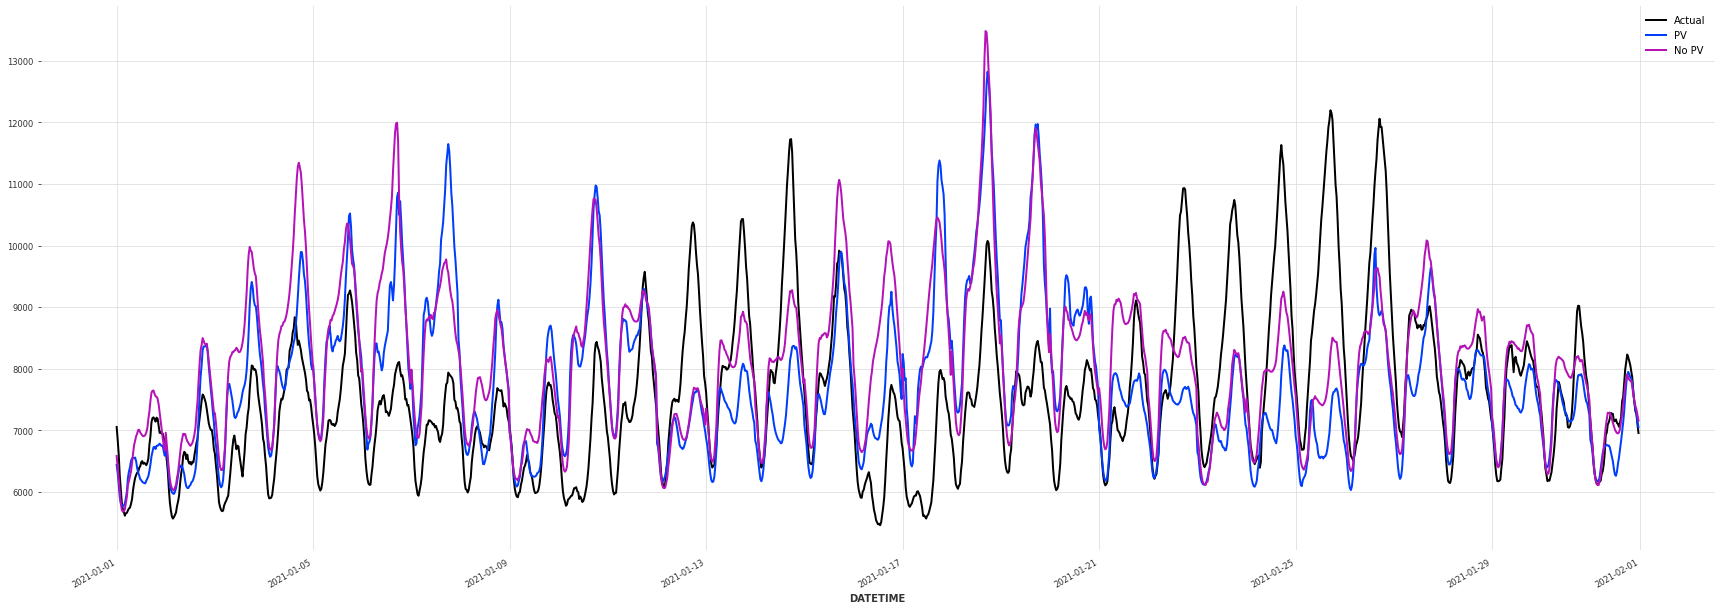

In [7]:
plt.figure(figsize=(30,10))
ref_series['TOTALDEMAND'].plot(label='Actual')
#ref_series['FORECASTDEMAND'].plot(label='AEMO')
pv_series.plot(label='PV')
#naive_forecasts.plot(label='naive')
no_pv_series.plot(label='No PV')

In [8]:
print("AEMO MAPE/RMSE:", mape(ref_series['TOTALDEMAND'], ref_series['FORECASTDEMAND']), rmse(ref_series['TOTALDEMAND'], ref_series['FORECASTDEMAND']))
print("Naive MAPE/RMSE:", mape(ref_series['TOTALDEMAND'], naive_forecasts), rmse(ref_series['TOTALDEMAND'], naive_forecasts))
print("PV prediction MAPE/RMSE", mape(ref_series['TOTALDEMAND'],pv_series), rmse(ref_series['TOTALDEMAND'],pv_series))
print("Non-PV prediction MAPE/RMSE", mape(ref_series['TOTALDEMAND'],no_pv_series), rmse(ref_series['TOTALDEMAND'],no_pv_series))



AEMO MAPE/RMSE: 2.1828593046777494 221.19896007523988
Naive MAPE/RMSE: 6.744142265683557 787.6581856076303
PV prediction MAPE/RMSE 13.480587033848613 1417.6697936186908
Non-PV prediction MAPE/RMSE 14.213008728579654 1397.90078309996


Calculate the residuals between the predictions and the actuals


In [9]:
pv_diffs = ref_series['TOTALDEMAND'] - pv_series
non_pv_diffs = ref_series['TOTALDEMAND'] - no_pv_series

## Histogram of the distribution of errors for PV and non-PV roll-forward forecasts

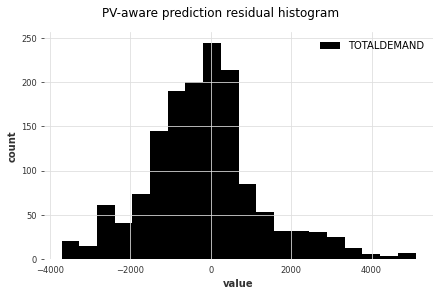

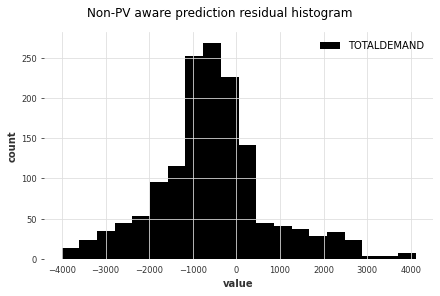

In [10]:
plot_hist(pv_diffs, bins=20, title="PV-aware prediction residual histogram")
plot_hist(non_pv_diffs, bins=20, title="Non-PV aware prediction residual histogram")

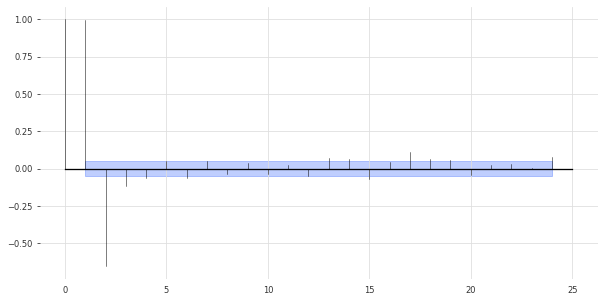

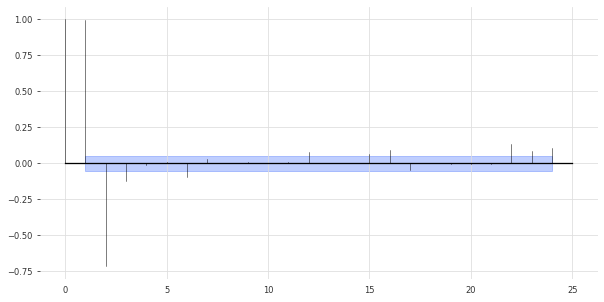

In [11]:
plot_pacf(pv_diffs, alpha=0.05)
plot_pacf(non_pv_diffs, alpha=0.05)

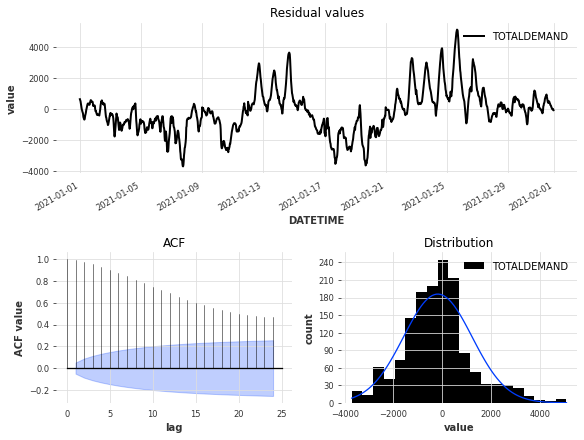

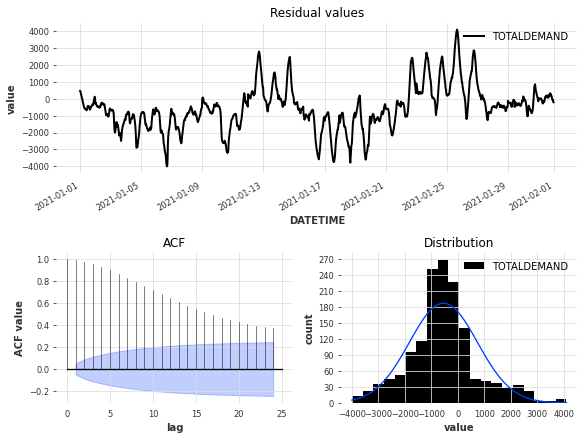

In [12]:
plot_residuals_analysis(pv_diffs)
plot_residuals_analysis(non_pv_diffs)

## Correlation of residuals with other predictors: PV data

In [13]:
def resid_correlation(residuals, main_data):
    cor_df = residuals.pd_dataframe()
    cor_df.rename(columns={'TOTALDEMAND':'RESIDUAL'}, inplace=True)
    return cor_df.merge(main_data, how='left', on='DATETIME')[['RESIDUAL','TOTALDEMAND','POWER','TEMPERATURE']].corr(method='pearson')

In [14]:
resid_correlation(pv_diffs, actual)

,RESIDUAL,TOTALDEMAND,POWER,TEMPERATURE
RESIDUAL,1.000000,0.605903,0.059859,0.474108
TOTALDEMAND,0.605903,1.000000,0.137381,0.633677
POWER,0.059859,0.137381,1.000000,0.646938
TEMPERATURE,0.474108,0.633677,0.646938,1.000000


## Correlation of residuals with other predictors: non-PV data

In [15]:
resid_correlation(non_pv_diffs, actual)

,RESIDUAL,TOTALDEMAND,POWER,TEMPERATURE
RESIDUAL,1.000000,0.558726,-0.110688,0.365438
TOTALDEMAND,0.558726,1.000000,0.137381,0.633677
POWER,-0.110688,0.137381,1.000000,0.646938
TEMPERATURE,0.365438,0.633677,0.646938,1.000000


Distribution of errors by time of day

In [16]:
def plot_residuals_by_hour(residuals):
    res = residuals.pd_dataframe()
    res.head()
    res.rename(columns={'TOTALDEMAND':'Residuals'},inplace=True)
    res['Time of day'] = res.index.time

    sns.set(rc={"figure.figsize": (25,5)})
    errorplot = sns.boxplot(data=res, x='Time of day',y='Residuals')
    errorplot.set_xticklabels(labels=res['Time of day'].unique(), rotation=45)
    ax1 = errorplot.axes
    ax1.axhline(0, ls='--', color='red')    

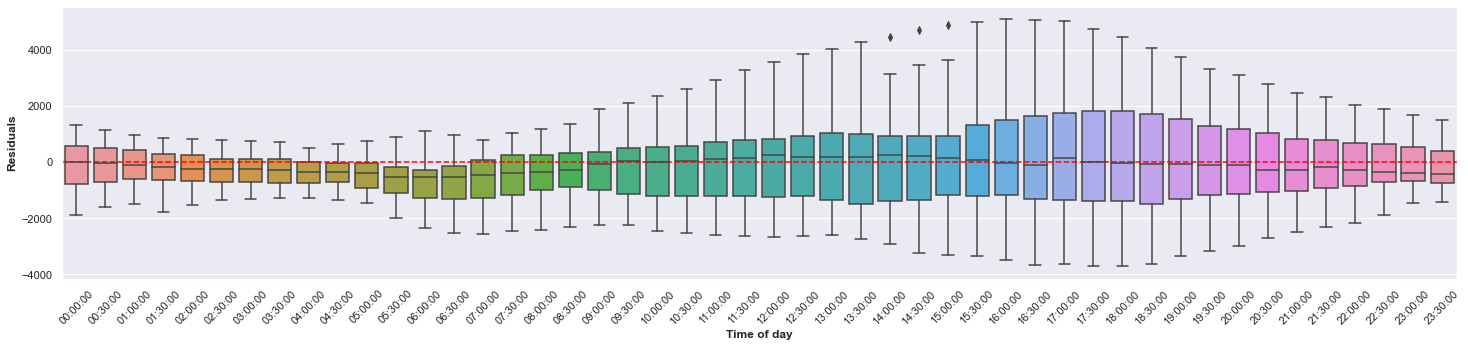

In [17]:


plot_residuals_by_hour(pv_diffs)

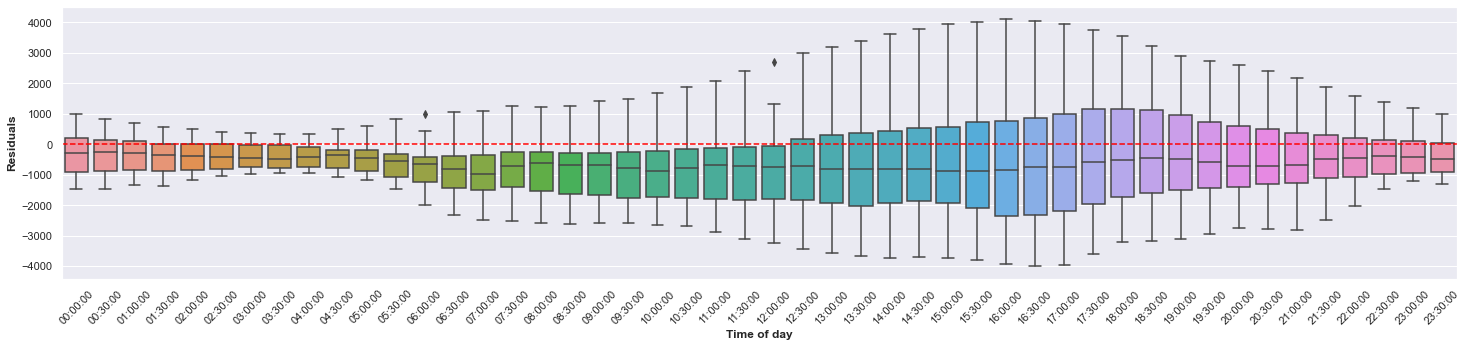

In [18]:
plot_residuals_by_hour(non_pv_diffs)

In [19]:
def daily_sum_relative_residuals(preds, actuals):
    preds_df = preds.pd_dataframe()
    preds_df.rename(columns={'TOTALDEMAND':'PREDICTION'}, inplace=True)
    merge_df = preds_df.merge(actuals, how='left', left_index=True, right_on='DATETIME')
    merge_df['relative_diff'] = abs((merge_df['PREDICTION'] - merge_df['TOTALDEMAND']) / merge_df['TOTALDEMAND'])
    return merge_df.groupby(by=merge_df['DATETIME'].dt.date).aggregate(sum)['relative_diff']

In [20]:
daily_pv_residuals = daily_sum_relative_residuals(pv_series, actual)

print("Best 5 days")
daily_pv_residuals.sort_values().head(5)

print("Worst 5 days")
daily_pv_residuals.sort_values(ascending=False).head(5)

print("All days ranked best to worst")
daily_pv_residuals.sort_values()

Best 5 days


DATETIME
2021-01-28    1.487719
2021-01-15    1.700599
2021-01-31    2.011046
2021-01-29    2.351767
2021-01-09    2.443015
Name: relative_diff, dtype: float64

Worst 5 days


DATETIME
2021-01-17    15.583780
2021-01-10    14.058919
2021-01-07    13.944582
2021-01-18    11.914830
2021-01-25    11.566106
Name: relative_diff, dtype: float64

All days ranked best to worst


DATETIME
2021-01-28     1.487719
2021-01-15     1.700599
2021-01-31     2.011046
2021-01-29     2.351767
2021-01-09     2.443015
2021-01-01     2.543190
2021-01-30     2.574598
2021-01-02     3.069517
2021-01-21     3.194290
2021-01-08     3.871786
2021-01-27     4.063652
2021-01-04     4.751038
2021-01-13     5.387549
2021-01-11     5.420708
2021-01-12     5.966336
2021-01-22     5.998193
2021-01-03     6.358373
2021-01-26     6.578092
2021-01-05     6.586201
2021-01-14     6.861024
2021-01-23     7.058087
2021-01-24     7.568383
2021-01-16     7.621296
2021-01-06     8.287515
2021-01-20     8.582201
2021-01-19    11.186741
2021-01-25    11.566106
2021-01-18    11.914830
2021-01-07    13.944582
2021-01-10    14.058919
2021-01-17    15.583780
Name: relative_diff, dtype: float64